<a href="https://colab.research.google.com/github/Hotckiss/DUL/blob/hw3/hw3_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.nn.utils as utils
from torch.optim import Adam

In [0]:
def sample_data_3():
    count = 100000
    rand = np.random.RandomState(0)
    a = [[-1.5, 2.5]] + rand.randn(count // 3, 2) * 0.2
    b = [[1.5, 2.5]] + rand.randn(count // 3 + 1, 2) * 0.2
    c = np.c_[2 * np.cos(np.linspace(0, np.pi, count // 3)),
    -np.sin(np.linspace(0, np.pi, count // 3))]
    c += rand.randn(*c.shape) * 0.2
    data_x = np.concatenate([a, b, c], axis=0)
    data_y = np.array([0] * len(a) + [1] * len(b) + [2] * len(c))
    perm = rand.permutation(len(data_x))
    return data_x[perm], data_y[perm]

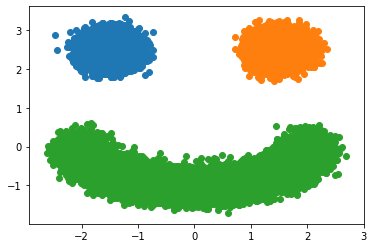

In [3]:
x, y = sample_data_3()
n_samples = x.shape[0]
idx = np.random.permutation(n_samples)
train_size = int(n_samples * 0.8)
x_train, y_train, x_test, y_test = x[idx[:train_size]], y[idx[:train_size]], x[idx[train_size:]], y[idx[train_size:]]
test_size = x_test.shape[0]

plt.scatter(x_train[y_train == 0, 0], x_train[y_train == 0, 1])
plt.scatter(x_train[y_train == 1, 0], x_train[y_train == 1, 1])
plt.scatter(x_train[y_train == 2, 0], x_train[y_train == 2, 1])
plt.show()

In [0]:
def MyLoss(x, mu, var):
    log_prob = torch.sum(-0.5 * (torch.log(np.pi * 2 * var) + torch.pow(x - mu, 2) / var), dim=1, keepdim=True)
    return -torch.sum(log_prob, dim=1, keepdim=True)

In [0]:
def KLDiv(mu, var):
    return -0.5 * torch.sum((1.0 + torch.log(var) - torch.pow(mu, 2) - var), dim=1, keepdim=True)

In [0]:
def sample(decoder, n_samples=100000):
    z = torch.randn([n_samples, 2]).cuda()
    mu_x, var_x = decoder(z)
    x = torch.randn([n_samples, 2]).cuda() * torch.sqrt(var_x) + mu_x
    return x, mu_x

In [0]:
def plot_data(train, validate, title_):
    ax = plt.subplot(111)
    ax.plot(np.arange(1, len(train) + 1),train, label='train')
    ax.plot(np.arange(1, len(validate) + 1) * val_steps, validate, label='val')
    ax.set_xlabel("n")
    ax.set_title(title_)
    ax.legend()

In [0]:
def plot_samples(x, mu_x):
    x = x.cpu().data.numpy()
    mu_x = mu_x.cpu().data.numpy()
    
    ax = plt.subplot(111)
    ax.scatter(x[:, 0], x[:, 1], label='path')
    ax.scatter(mu_x[:, 0], mu_x[:, 1], label='mean')
    ax.legend()

In [0]:
def var_calcer_1(log_var):
    return torch.exp(log_var)

In [0]:
class MyNet(nn.Module):
    def __init__(self, out_size, var_calcer, n_layers=5, n_features=512):
        super(MyNet, self).__init__()
        self.n_features = n_features
        self.n_layers = n_layers
        self.layers = nn.ModuleList()
        self.out_size = out_size
        self.var_calcer = var_calcer

        self.in_layer = nn.Linear(2, self.n_features)
        for i in range(n_layers - 2):
            self.layers.append(nn.Linear(n_features, self.n_features))
        self.outlayer = nn.Linear(self.n_features, out_size)
            
    def forward(self, x):
        x = torch.relu(self.in_layer(x))
        for layer in self.layers:
            x = torch.relu(layer(x)) + x
        mu, log_var = torch.split(self.outlayer(x), 2, dim=1)
        var = self.var_calcer(log_var)
        return mu, var

In [0]:
num_epoch = 10000
lr = 2e-4
batch_size = 10000
val_steps = 4

In [0]:
def train(encoder, decoder, train_data, val_data):
    train_size = train_data.shape[0]
    val_size = val_data.shape[0]
    val_batch = torch.from_numpy(val_data).float().cuda()
    
    optimizer1, optimizer2 = Adam(encoder.parameters(), lr=lr), Adam(decoder.parameters(), lr=lr)
    KLD_t, losses_t, var_t, KLD_v, losses_v, var_v = [], [], [], [], [], []

    for i in range(num_epoch):
        idx = np.random.permutation(train_size)
        for j in range(train_size // batch_size):
            batch = torch.from_numpy(train_data[idx[j * batch_size : (j + 1) * batch_size]]).float().cuda()

            mu_z, var_z = encoder(batch)
            mu_x, var_x = decoder(mu_z + torch.sqrt(var_z) * torch.randn(batch.shape).cuda())

            nll, KL = MyLoss(batch, mu_x, var_x), KLDiv(mu_z, var_z)
            total_loss = torch.mean(nll + KL)

            optimizer1.zero_grad()
            optimizer2.zero_grad()
            total_loss.backward()
            utils.clip_grad_norm_(encoder.parameters(), 1.0)
            utils.clip_grad_norm_(decoder.parameters(), 1.0)
            optimizer1.step()
            optimizer2.step()

            losses_t.append(torch.mean(nll).detach().item() / 2.0)
            KLD_t.append(torch.mean(KL).detach().item())
            var_t.append(torch.mean(-total_loss).detach().item())
            
            if (i * num_epoch + j + 1) % val_steps == 0:
                with torch.no_grad():
                    mu_z, var_z = encoder(val_batch)
                    mu_x, var_x = decoder(mu_z + torch.sqrt(var_z) * torch.randn(val_batch.shape).cuda())
                    val_nll = MyLoss(val_batch, mu_x, var_x)
                    val_kl = KLDiv(mu_z, var_z)
                    losses_v.append(torch.mean(val_nll).detach().item() / 2.0)
                    KLD_v.append(torch.mean(val_kl).detach().item())
                    var_v.append(torch.mean(-(val_nll + val_kl)).detach().item())

    return var_t, var_v, KLD_t, KLD_v, losses_t, losses_v

In [0]:
encoder = MyNet(4, var_calcer_1, n_layers=3, n_features=512).cuda()
decoder = MyNet(4, var_calcer_1, n_layers=3, n_features=512).cuda()

var_t, var_v, KLD_t, KLD_v, losses_t, losses_v = train(encoder, decoder, x_train, x_test)

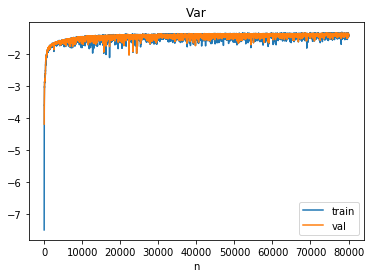

In [37]:
plot_data(var_t, var_v, "Var")

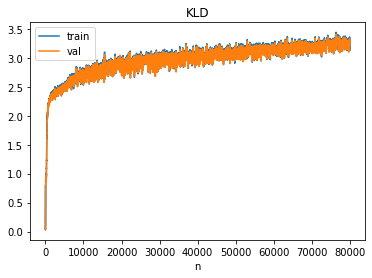

In [38]:
plot_data(KLD_t, KLD_v, "KLD")

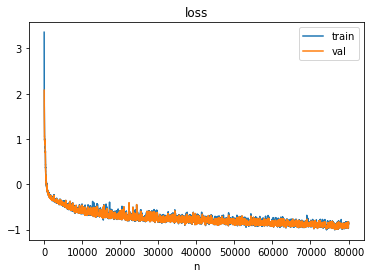

In [39]:
plot_data(losses_t, losses_v, "loss")

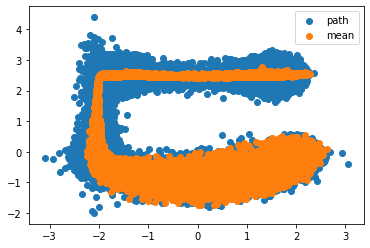

In [40]:
x, mu_x = sample(decoder, 100000)
plot_samples(x, mu_x)